# Real and Fake News Machine Learning LSTM Model #

## Library Import ##

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
from wordcloud import WordCloud

## Fake News Explore ##

In [11]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')


In [12]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [13]:
# columns of the DataFrame
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [14]:
fake.shape

(23481, 4)

In [15]:
fake = fake.dropna()
fake.shape

(23481, 4)

In [16]:
# How many subject we have and how much for each
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

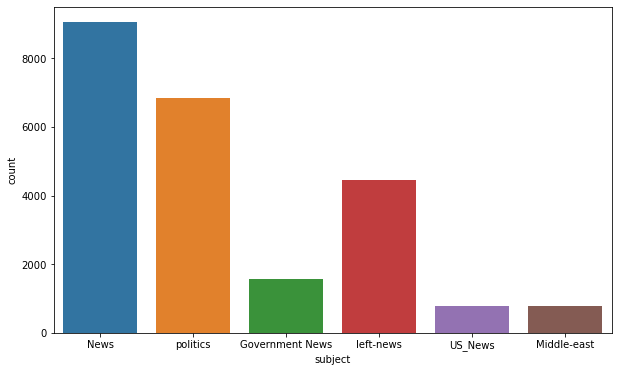

In [17]:
# visualizing the data for subject
plt.figure(figsize=(10,6)) # so the title of the columns don't overlap on each other
sns.countplot(x='subject', data=fake)

## Wordcloud ##

In [18]:
type(fake['text'].tolist())

list

In [19]:
text = ' '.join(fake['text'].tolist()) # all the words will join with a space between them

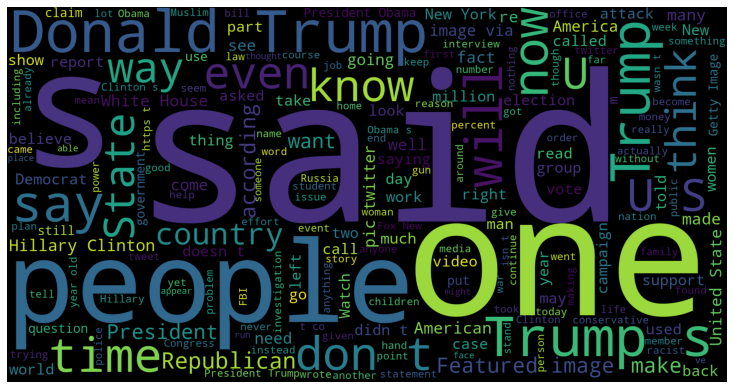

In [21]:
# wordcloud a bit improve
wordcloud = WordCloud(width=1920, height=1000).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud) # you can change setting colour and personalize it
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Exploring Real News ##

In [22]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [23]:
text = ' '.join(real['text'].tolist())

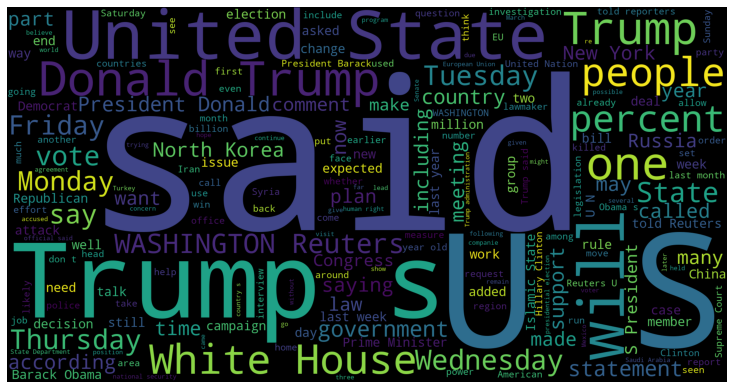

In [24]:
# wordcloud of real news
wordcloud = WordCloud(width=1920, height=1000).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud) # you can change setting colour and personalize it
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Different Text ###
Real News seems to have the source of publication or information which isn't present in the fake news wordcloud.

Looking at the real dataset:


*   most of the text contains **Reuters** informations like **Washington Reuters**
*   some text are tweets from Twitter
*   few text don't contain any publication info



## Cleaning Data ##
Removing Reuters or Twitter Tweet information from the text


*   Text can be splitted only once at '-' which is always present after mentioning source of publication, this gives us publication part and text part
*   if we don't get text part this publication details wasn't given for that record
*   Twitter tweets always have the same criteria, a long text of max 259 characters

In [25]:
real.sample(5)

,title,text,subject,date
5377,Trump's pick for national security adviser tur...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"February 16, 2017"
13868,Sacked Catalan leader challenges EU to respect...,"OOSTKAMP, Belgium (Reuters) - Catalonia s form...",worldnews,"November 25, 2017"
2015,U.S. state election officials still in the dar...,"ANAHEIM, Calif. (Reuters) - The federal govern...",politicsNews,"August 25, 2017"
8762,"Factbox: Five facts about Mike Pence, Trump's ...",(Reuters) - Republican Donald Trump will name ...,politicsNews,"July 14, 2016"
5368,"Trump's team in disarray, U.S. Senator McCain ...","MUNICH, Germany (Reuters) - Republican Senator...",politicsNews,"February 17, 2017"


In [26]:
real.shape

(21417, 4)

In [27]:
real = real.dropna()
real.shape

(21417, 4)

In [28]:
# list of indexes that don't have publication informations
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split("-", maxsplit=1)
    record[1] # for rows whose don't have text data

    assert(len(record[0])<120) # for tweets data
  except:
    unknown_publishers.append(index)


In [29]:
len(unknown_publishers)

222

In [30]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [31]:
# drop empty row
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [32]:
real = real.drop(8970, axis=0)

In [33]:
# put a new column for publishers
publisher = [] 
tmp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row) # row is the particular text
    publisher.append('Unknown')
  else: #if it's not inside the list of unknown publishers
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [34]:
# create a new column
real['publisher'] = publisher
real['text'] = tmp_text

In [35]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [36]:
real.shape

(21416, 5)

In [37]:
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [38]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [39]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

In [40]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

## Preprocessing Text ##

In [41]:
real['class'] = 1
fake['class'] = 0

In [42]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [43]:
# take off the columns you don't need
real = real[['text', 'class']]

In [44]:
fake = fake[['text', 'class']]

In [45]:
# put fake news and real news together
data = real.append(fake, ignore_index=True)

In [46]:
data.sample(5)

,text,class
1068,Republicans in House launch probe of Russia de...,1
13950,Egypt declares three days of mourning after at...,1
10007,"U.S. hands over 1,100 pages of Benghazi record...",1
17959,Ethnic land dispute forces thousands to flee i...,1
43423,Boiler Room EP #126 – Immigration Consternatio...,0


In [48]:
X = data.drop('class', axis=1)
y = data['class']

In [49]:
X.shape, y.shape

((44897, 1), (44897,))

In [50]:
import nltk
import re
from nltk.corpus import stopwords

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlotteportenseigne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
# Preprocessing data
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []

for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['text'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [42]:
# import pickle
# # saving
# with open('corpus.pickle', 'wb') as handle:
#     pickle.dump(corpus, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('corpus.pickle', 'rb') as handle:
#     corpus = pickle.load(handle)

In [71]:
import pickle
with open('corpus.pickle', 'rb') as handle:
    corpus = pickle.load(handle)

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

In [73]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus) # kind of words embedding into integer

In [74]:
# index for each word
tokenizer.word_index 

{'trump': 1,
 'said': 2,
 'state': 3,
 'presid': 4,
 'u': 5,
 'would': 6,
 'peopl': 7,
 'year': 8,
 'republican': 9,
 'say': 10,
 'one': 11,
 'elect': 12,
 'new': 13,
 'hous': 14,
 'obama': 15,
 'govern': 16,
 'also': 17,
 'clinton': 18,
 'like': 19,
 'report': 20,
 'time': 21,
 'democrat': 22,
 'donald': 23,
 'nation': 24,
 'call': 25,
 'support': 26,
 'american': 27,
 'countri': 28,
 'unit': 29,
 'right': 30,
 'white': 31,
 'senat': 32,
 'campaign': 33,
 'make': 34,
 'go': 35,
 'parti': 36,
 'could': 37,
 'vote': 38,
 'told': 39,
 'offici': 40,
 'two': 41,
 'get': 42,
 'last': 43,
 'news': 44,
 'use': 45,
 'polit': 46,
 'want': 47,
 'work': 48,
 'offic': 49,
 'includ': 50,
 'law': 51,
 'first': 52,
 'back': 53,
 'group': 54,
 'take': 55,
 'even': 56,
 'hillari': 57,
 'video': 58,
 'secur': 59,
 'day': 60,
 'former': 61,
 'us': 62,
 'week': 63,
 'show': 64,
 'court': 65,
 'media': 66,
 'attack': 67,
 'mani': 68,
 'plan': 69,
 'polic': 70,
 'may': 71,
 'bill': 72,
 'come': 73,
 'made':

In [75]:
voc_size = len(tokenizer.word_index) +1

In [76]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

## Embedding Representation ##

In [77]:
sent_length = 20
embedded_docs = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [78]:
embedded_docs[0]

array([54489, 55546, 43922, 82845, 14984, 29479, 10682, 77365, 17236,
       55546,  4749, 67341, 45050,  9706, 25067, 48322, 59947, 32056,
       88154, 54489], dtype=int32)

## LSTM Model ##

In [79]:
# Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 40)            3591360   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,647,861
Trainable params: 3,647,861
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
# Creating model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Dropout(0.3))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 40)            3591360   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               112800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 3,704,361
Trainable params: 3,704,361
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
len(embedded_docs), y.shape
# continue with How to do up, lstm, classification , accurency

(44897, (44897,))

In [82]:
import numpy as np
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [83]:
X_final.shape, y_final.shape

((44897, 20), (44897,))

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

## Model Training ##

In [85]:
# Finally Training
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=100)

Epoch 1/10
301/301 [==============================] - 24s 79ms/step - loss: 0.1862 - accuracy: 0.9205 - val_loss: 0.1211 - val_accuracy: 0.9582
Epoch 2/10
301/301 [==============================] - 25s 82ms/step - loss: 0.0651 - accuracy: 0.9785 - val_loss: 0.1239 - val_accuracy: 0.9626
Epoch 3/10
301/301 [==============================] - 25s 82ms/step - loss: 0.0370 - accuracy: 0.9883 - val_loss: 0.1120 - val_accuracy: 0.9641
Epoch 4/10
301/301 [==============================] - 24s 80ms/step - loss: 0.0201 - accuracy: 0.9937 - val_loss: 0.1455 - val_accuracy: 0.9640
Epoch 5/10
301/301 [==============================] - 24s 81ms/step - loss: 0.0150 - accuracy: 0.9949 - val_loss: 0.1618 - val_accuracy: 0.9636
Epoch 6/10
301/301 [==============================] - 25s 82ms/step - loss: 0.0125 - accuracy: 0.9953 - val_loss: 0.1875 - val_accuracy: 0.9588
Epoch 7/10
301/301 [==============================] - 25s 82ms/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.1752 - val_accuracy:

## Performance and Metric Accurancy ##

In [86]:
y_pred1 = model1.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [87]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred1)

array([[7340,  356],
       [ 212, 6909]])

In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

0.9616656543159884

In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7696
           1       0.95      0.97      0.96      7121

    accuracy                           0.96     14817
   macro avg       0.96      0.96      0.96     14817
weighted avg       0.96      0.96      0.96     14817

